## Data Analytics - Lab 4 - Linear models
<br>
Jan Pomykacz<br>
Nr. albumu: 401623<br>
Grupa: czwartek, 9:30


We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [175]:
from cmdstanpy import CmdStanModel

from seaborn import jointplot
import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [176]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()
d.describe()

,height,weight,age,male
count,352.000000,352.000000,352.000000,352.000000
mean,154.597093,44.990486,41.138494,0.468750
std,7.742332,6.456708,15.967855,0.499733
min,136.525000,31.071052,18.000000,0.000000
25%,148.590000,40.256290,28.000000,0.000000
50%,154.305000,44.792210,39.000000,0.000000
75%,160.655000,49.292693,51.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


## Task 1. Prior predictive checks

In [177]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.




1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors.
4. Correct prior parameters to make them reasonably spreaded out. 
5. Check if observed data is possible to obtain using priors.

Text(0, 0.5, 'Amount')

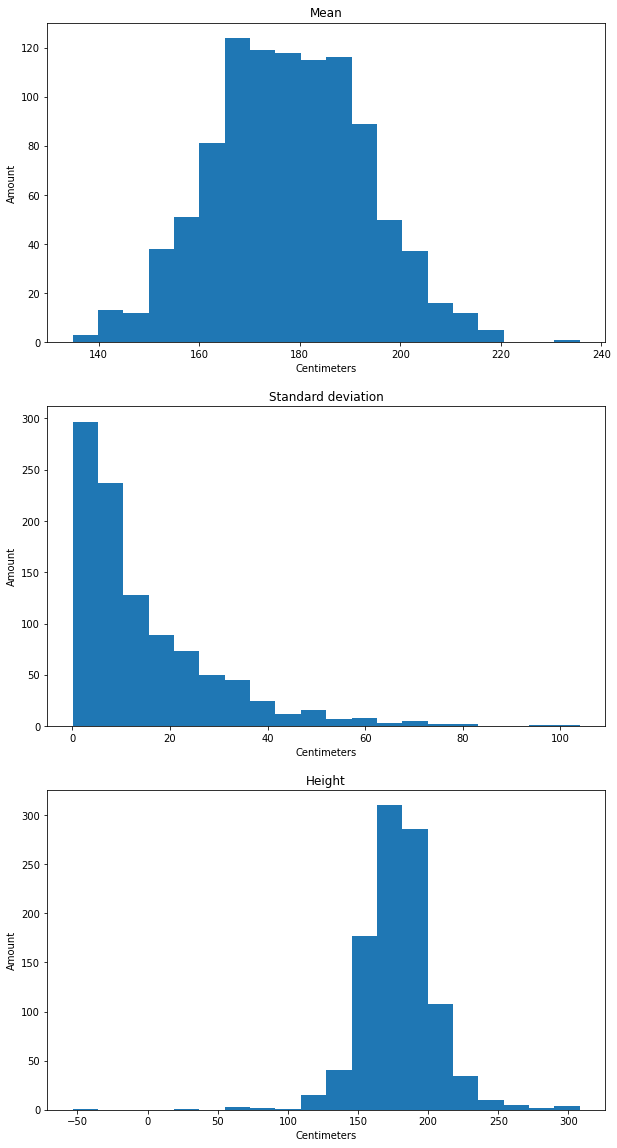

In [178]:
# Ad1
prior_height = sim.draws_pd()
prior_height.head()
fig, axes = plt.subplots(3,1, figsize=(10,20))
axes[0].hist(prior_height["mu"],bins=20, label='Mean')
axes[0].set_title("Mean")
axes[0].set_xlabel("Centimeters")
axes[0].set_ylabel("Amount")

axes[1].hist(prior_height["sigma"],bins=20,label='Std')
axes[1].set_title("Standard deviation")
axes[1].set_xlabel("Centimeters")
axes[1].set_ylabel("Amount")

axes[2].hist(prior_height["height"],bins=20, label='Height')
axes[2].set_title("Height")
axes[2].set_xlabel("Centimeters")
axes[2].set_ylabel("Amount")

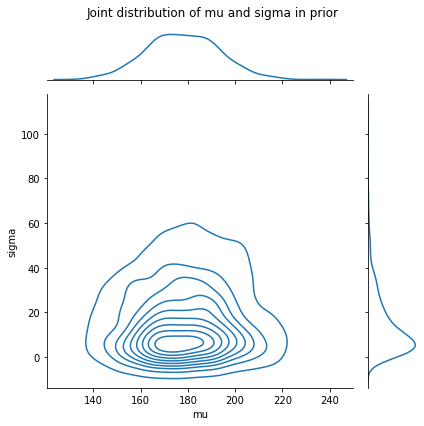

In [179]:
#Ad2
jointplot(prior_height[["mu","sigma"]],x=prior_height["mu"],y=prior_height["sigma"],kind="kde")
plt.suptitle("Joint distribution of mu and sigma in prior")
plt.tight_layout()

#Ad3,4 <br>
Samples are rather consistent with priors. Different priors were tested, sigma was modelled with exponential and normal distribution. Overall I think that using uniform distribution for this case gives best result.

In [180]:
#Ad5
#If by observed data we understand !Kung people height data, then it can be modelled with priors to some extent.
# model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

# R = 352
# sim=model_ppc.sample(iter_sampling=R,
#                      iter_warmup=0,
#                      chains=1,
#                      fixed_param=True,
#                      seed=29042020,refresh=R)
# prior_fit = sim.draws_pd()
# plt.hist(d["height"], bins=20, alpha=0.5, label="Measured data")
# plt.hist(prior_fit["height"], bins=20, alpha=0.5, label="Simulated data")
# plt.legend()

Above code was used as my best attempt at trying to model observed data with priors only. I think its possible to do a better job, but for me this is 'good enough'.<br>
Below picture of my best try.<br>

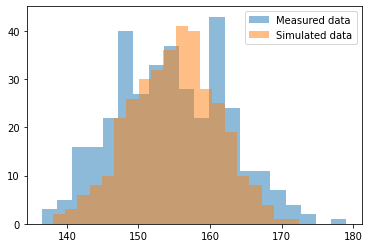

## Task 2. Model fit and evaluation

In [181]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [182]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.



1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.


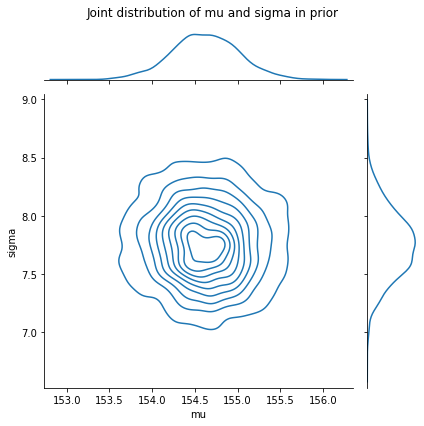

Text(0, 0.5, 'Normalized amount')

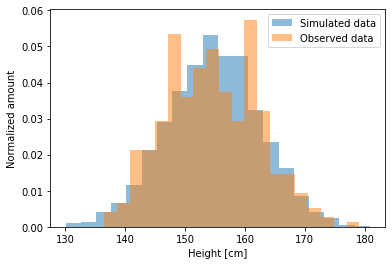

In [183]:
# Ad1
df_fit = fit.draws_pd()
df_fit.head()
jointplot(df_fit[["mu", 'sigma']], x=df_fit["mu"], y=df_fit["sigma"], kind="kde")
plt.suptitle("Joint distribution of mu and sigma in prior")
plt.tight_layout()
plt.show()

# Ad 2
plt.hist(df_fit["height"], density=True, bins=20, alpha=0.5, label="Simulated data")
plt.hist(d["height"], density=True, bins=20, alpha=0.5, label="Observed data")
plt.legend()
plt.xlabel("Height [cm]")
plt.ylabel("Normalized amount")


Above histograms shows that posterior prediction for our dataset is quite good.

## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [184]:
d["c_weight"] = d["weight"].mean() - d["weight"]
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}


## Task 4. Prior predictive checks
 

In [185]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

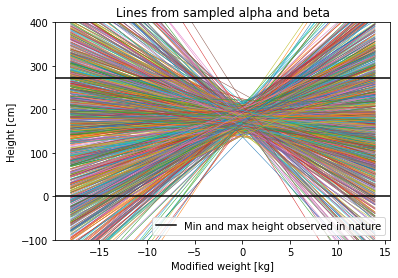

In [186]:
df_sim = sim.draws_pd()
df_sim.describe()

min_weight,max_weight = d.c_weight.min(),d.c_weight.max()
plt.plot([min_weight,max_weight],[df_sim["alpha"]+df_sim["beta"]*min_weight, df_sim["alpha"]+df_sim["beta"]*max_weight],linewidth=0.5)
plt.axhline(y=272, color='k', label="Min and max height observed in nature")
plt.axhline(y=0, color='k')
plt.ylim(-100,400)
plt.title("Lines from sampled alpha and beta")
plt.xlabel("Modified weight [kg]")
plt.ylabel("Height [cm]")
plt.legend()

Black lines are 0 and 272cm height. As we see only small portion of lines are somewhat consistent with those two values.

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [187]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [188]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

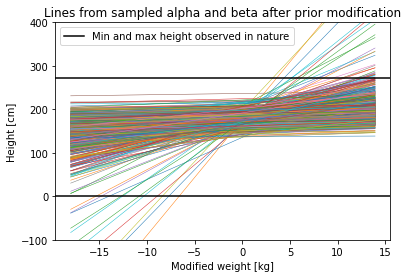

In [189]:
#Ad 1. Using lognormal distribution helped. Now majority of lines stays within bounds
df_sim = sim.draws_pd()

plt.plot([min_weight,max_weight],[df_sim["alpha"]+df_sim["beta"]*min_weight, df_sim["alpha"]+df_sim["beta"]*max_weight],linewidth=0.5)
plt.axhline(y=272, color='k', label="Min and max height observed in nature")
plt.axhline(y=0, color='k')
plt.ylim(-100,400)
plt.title("Lines from sampled alpha and beta after prior modification")
plt.xlabel("Modified weight [kg]")
plt.ylabel("Height [cm]")
plt.legend()

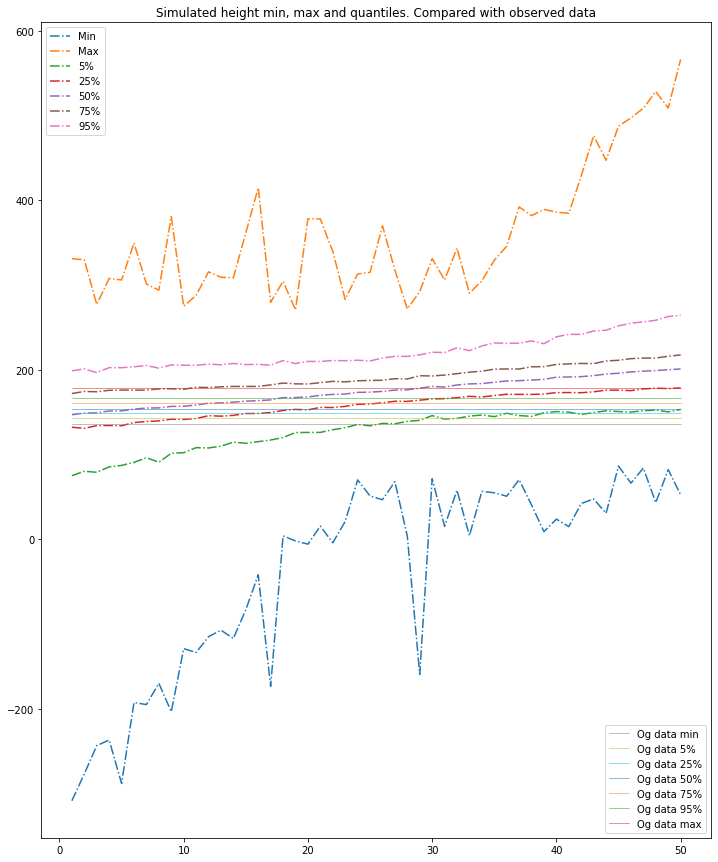

In [190]:
#Ad 2. I assume that we want to plot these values for height, not weight, as we dont simulate latter one
sim_stats = df_sim.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
sim_50 = sim_stats.loc[['mean']].iloc[:,5:]
sim_5 = sim_stats.loc[['5%']].iloc[:,5:]
sim_25 = sim_stats.loc[['25%']].iloc[:,5:]
sim_75 = sim_stats.loc[['75%']].iloc[:,5:]
sim_95 = sim_stats.loc[['95%']].iloc[:,5:]
sim_max = sim_stats.loc[['max']].iloc[:,5:]
sim_min = sim_stats.loc[['min']].iloc[:,5:]

x = np.linspace(1,50)

plt.figure(figsize=(12,15))
line1, = plt.plot(x, sim_min.values.T, '-.', label="Min")
line2, = plt.plot(x, sim_max.values.T, '-.', label="Max")
line3, = plt.plot(x, sim_5.values.T, '-.', label="5%")
line4, = plt.plot(x, sim_25.values.T, '-.', label="25%")
line5, = plt.plot(x, sim_50.values.T, '-.', label="50%")
line6, = plt.plot(x, sim_75.values.T, '-.', label="75%")
line7, = plt.plot(x, sim_95.values.T, '-.', label="95%")
plt.title("Simulated height min, max and quantiles. Compared with observed data")
legend1 = plt.legend(handles=[line1,line2,line3,line4,line5,line6,line7],loc='upper left')
plt.gca().add_artist(legend1)

#plotting lines for data
data_stats = d.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])["height"].drop(["count","std","mean"])
lines2 = []
for name,stat in data_stats.items():
    line, = plt.plot([1,50],[stat,stat], linewidth=0.5, label="Og data "+name)
    lines2.append(line)
plt.legend(handles=lines2, loc='lower right')
plt.show()

Observed data are possible in prior model, but not likely to be observed. Og data lines represent min, max and analogous quantiles for observed data. We see that max value is around model's mean, all quantiles are between 25% and 5% model's quantiles and min of observed data is below 5% quantile of model.

## Task 6. Fitting and evaluating model


In [191]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [192]:
N = 50
data_fit = {'N': N, 'weight': d.weight.iloc[:N].values, 'heights': d.height.iloc[:N].values}
fit=model_2_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status



chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


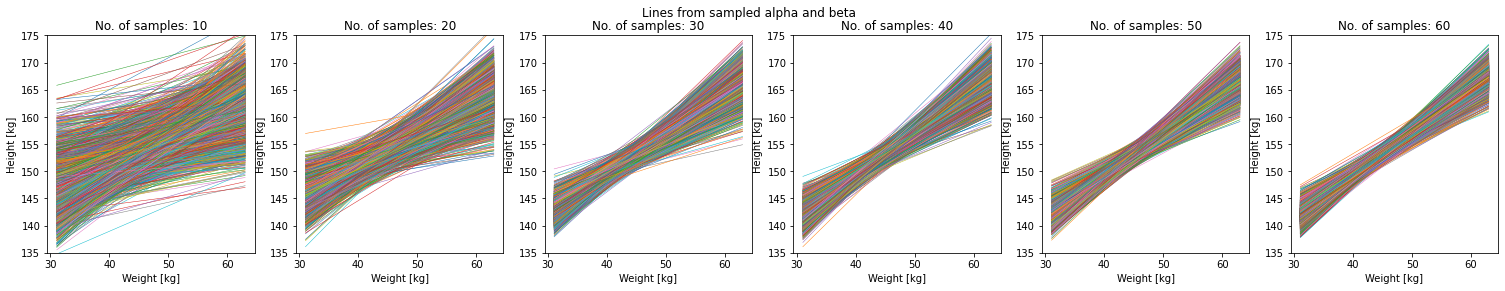

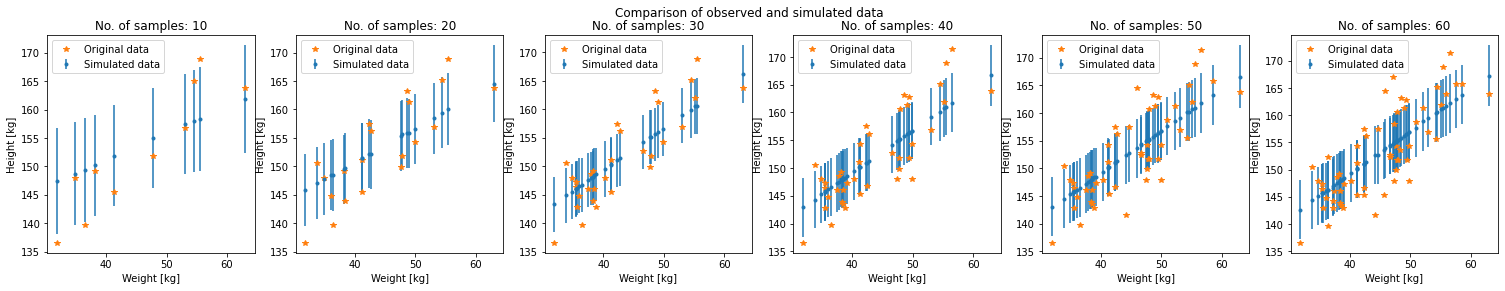

In [193]:
#Ad2. More samples we provide the more certain model becomes
#Ad3. Majority of data is able to be observed in posterior model, but not all of them. With increased number of samples std is getting lower for each height.

list_of_Ns = [10,20,30,40,50,60]
min_weight, max_weight = d.weight.min(),d.weight.max()

fig, axes = plt.subplots(1,6, figsize=(26,4))
fig2, axes2 = plt.subplots(1,6, figsize=(26,4))
axes = axes.flatten()
for (idx, N) in enumerate(list_of_Ns):

    data_fit = {'N': N, 'weight': d.weight.iloc[:N].values, 'heights': d.height.iloc[:N].values}
    fit=model_2_fit.sample(data=data_fit,seed=28052020)
    df_fit = fit.draws_pd()

    fig
    fig.suptitle("Lines from sampled alpha and beta")
    axes[idx].plot([min_weight,max_weight],[df_fit["alpha"]+df_fit["beta"]*min_weight, df_fit["alpha"]+df_fit["beta"]*max_weight],linewidth=0.5)
    axes[idx].set_ylim(135,175)
    axes[idx].set_title("No. of samples: {0}".format(N))
    axes[idx].set_xlabel("Weight [kg]")
    axes[idx].set_ylabel("Height [kg]")

    fig2
    fig2.suptitle("Comparison of observed and simulated data")
    df_fit = df_fit.describe()
    axes2[idx].errorbar(d.weight.iloc[:N].values,df_fit.loc[["mean"]].iloc[:,-N:].to_numpy()[0], yerr=df_fit.loc[["std"]].iloc[:,-N:].to_numpy()[0], fmt='.', label="Simulated data")
    axes2[idx].plot(d.weight.iloc[:N].values,d.height.iloc[:N].values, '*', label="Original data")
    axes2[idx].set_title("No. of samples: {0}".format(N))
    axes2[idx].set_xlabel("Weight [kg]")
    axes2[idx].set_ylabel("Height [kg]")
    axes2[idx].legend()


## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?
2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.
3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block. 

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


Text(0, 0.5, 'Height [cm]')

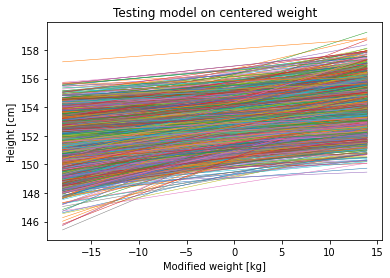

In [194]:
#Ad1. For this model  alpha in this case tells us what height our model expects when weight of individual is equal to mean weight
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')
N = 50
data_fit = {'N': N, 'weight': d.c_weight.iloc[:N].values, 'heights': d.height.iloc[:N].values}
fit=model_2_fit.sample(data=data_fit,seed=28052020)

df_fit = fit.draws_pd()
min_weight,max_weight = d.c_weight.min(),d.c_weight.max()

plt.plot([min_weight,max_weight],[df_fit["alpha"]+df_fit["beta"]*min_weight, df_fit["alpha"]+df_fit["beta"]*max_weight],linewidth=0.5)
plt.title("Testing model on centered weight")
plt.xlabel("Modified weight [kg]")
plt.ylabel("Height [cm]")

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


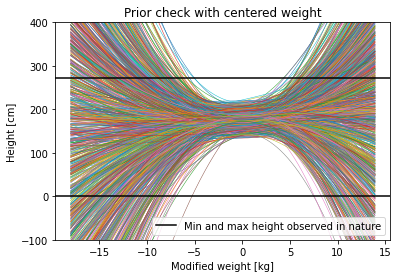

In [195]:
#Ad2. Prior predictive checks
model_3_ppc=CmdStanModel(stan_file='height_3_ppc.stan')

R=1000
min_weight,max_weight = d.c_weight.min(),d.c_weight.max()

data_sim = data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}
sample = model_3_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

df_sample = sample.draws_pd()

x = np.linspace(min_weight, max_weight, 1000)


for iter in range(1000):
    plt.plot(x, df_sample["alpha"][iter]+df_sample["beta"][iter]*x+df_sample["beta2"][iter]*(x**2),linewidth=0.5)

plt.axhline(y=272, color='k', label="Min and max height observed in nature")
plt.axhline(y=0, color='k')
plt.ylim(-100,400)
plt.title("Prior check with centered weight")
plt.xlabel("Modified weight [kg]")
plt.ylabel("Height [cm]")
plt.legend(loc='best')


Above prior have potential; they're quite accurate at weight = weight.mean(). Let's see how well it fits the data.

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


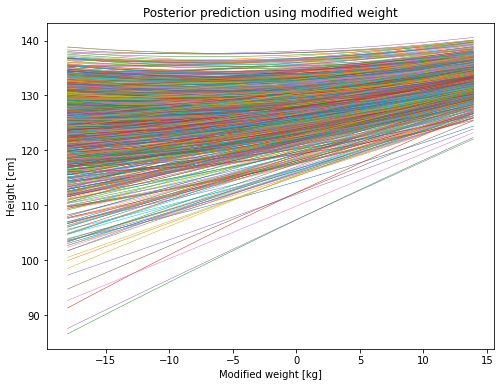

Text(0, 0.5, 'Height [cm]')

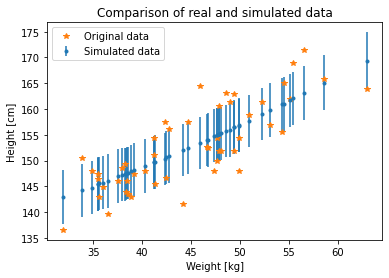

In [196]:
#Ad2 Fitting model
model_3_fit=CmdStanModel(stan_file='height_3_fit.stan')
N = 50
data_fit = {'N': N, 'weight': d.weight.iloc[:N].values, 'heights': d.height.iloc[:N].values}
fit=model_3_fit.sample(data=data_fit,seed=28052020)

df_fit = fit.draws_pd()
min_weight,max_weight = d.weight.min(),d.weight.max()

plt.figure(figsize=(8,6))
for iter in range(1000):
    plt.plot(x, df_fit["alpha"][iter]+df_fit["beta"][iter]*x+df_fit["beta2"][iter]*(x**2),linewidth=0.5)
plt.title("Posterior prediction using modified weight")
plt.xlabel("Modified weight [kg]")
plt.ylabel("Height [cm]")
plt.show()

df_fit = df_fit.describe()

plt.errorbar(d.weight.iloc[:N].values,df_fit.loc[["mean"]].iloc[:,-N:].to_numpy()[0], yerr=df_fit.loc[["std"]].iloc[:,-N:].to_numpy()[0], fmt='.', label="Simulated data")
plt.plot(d.weight.iloc[:N].values,d.height.iloc[:N].values, '*', label="Original data")
plt.legend()
plt.title("Comparison of real and simulated data")
plt.xlabel("Weight [kg]")
plt.ylabel("Height [cm]")



Overall model is still good for predicting !Kung adults heights based on their weights. Using polynomial regression might 'shine' when using whole dataset - with children. We expect some non-linearity there, so second order or higher polynomials probably will fit better.